In [1]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np_  # Original numpy
import pennylane as qml
import scipy as sp
from autograd import grad

# Pennylane numpy
from pennylane import numpy as np 

In [2]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
coeffs = [-0.5]
obs = [qml.PauliZ(0)]
hamiltonian = qml.Hamiltonian(coeffs, obs)

In [3]:
# Global Parameters
Tau_global = 5e-2   # Dephase tau
Paras_global = np.zeros(2)
Phi_global = 0
Gamma_ps = 0

def Dephase_factor(tau):
    """
    Calculate the dephasing factor (gamma) based on the provided tau value.

    Args:
        tau (float): Dephasing time constant.

    Returns:
        float: Calculated dephasing factor (gamma).
    """
    return 1 - np.exp(-2 * tau)

$$
\rho_{After_Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-t} = \sqrt{1 - \gamma}
$$

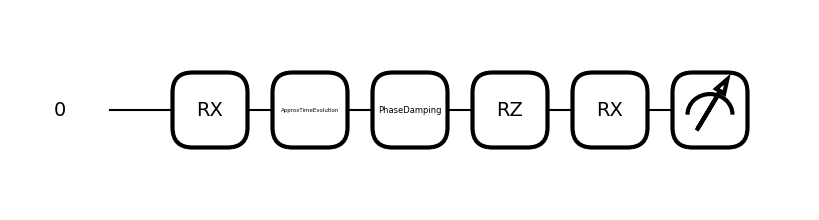

In [4]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([
        [np.sqrt(1 - Gamma_ps), 0],
        [0, 1]
    ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [5]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return 1.9443 - CFI

In [6]:
jacobian = grad(Cost_function)

In [7]:
class DataIndex(Enum):
    BEFORE = 0
    PHI = 0
    CFI = 1
    PARAS = 2
    THETA_X = 2
    PHI_Z = 3

# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(sweep_data, initial_parameters, gamma_ps, iterations):
    """ 
    Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        sweep_data (tuple): (start, end, step) values for the sweep.
        initial_parameters (numpy_array): Array of parameters for the qnode.
        gamma_ps (int): The Gamma value for post-selection.
        iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array containing phi, CFI, and optimized parameters.
    """
    
    # Create Data array
    PHI = np_.arange(sweep_data[0], sweep_data[1], sweep_data[2])
    Data = np_.zeros((iterations + 1, len(PHI), len(initial_parameters) + 2)) 
    Data[:, :, DataIndex.PHI.value] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Store initial CFI data and parameters
    for idx, phi in enumerate(PHI):
        Data[DataIndex.BEFORE.value][idx][DataIndex.CFI.value] = -Cost_function(initial_parameters)
        Data[DataIndex.BEFORE.value][idx][DataIndex.PARAS.value:] = initial_parameters
        
    # Optimize begin
    for iteration in range(1, iterations + 1):
        for phi_idx, phi_current in enumerate(PHI):
            # Determine initial parameters based on the iteration
            if iteration == 1:
                Paras_Temporary = initial_parameters
                
            else:
                Paras_Temporary = Data[iteration][phi_idx][DataIndex.PARAS.value:]
            
            # Update the global Phi value
            Phi_global = phi_current
            
            # Determine constraints
            Constraints = get_constraints(phi_current, gamma_ps)
                
            # Optimize the data
            N = int(phi_current / 2*np.pi) * 2*np.pi
            slope = 1
            preset = 2.67, 1.09
            # if Gamma_ps == 8e-1:
            #     if phi_current <= 1.5707 + np.pi + N:
            #         Paras_Temporary = np.array([np.pi/2, slope * (phi - N) + preset[0]])
                
            #     elif 1.5707 + np.pi + N <= phi_current <= (1.5707 + np.pi)*2 + N:
            #         Paras_Temporary = np.array([np.pi/2, slope * (phi - (1.5707 + np.pi + N)) + preset[1]])
                
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(
                fun = Cost_function, 
                x0 = Paras_Temporary, 
                jac = jacobian,
                method = 'trust-constr', 
                bounds = Constraints,
                
                tol = 1e-30,
                options={
                    # 'ftol': 1e-30, 
                    'gtol': 1e-30
                }
            )
            Data[iteration][phi_idx][DataIndex.CFI.value] = -Result_BFGS.fun
            Data[iteration][phi_idx][DataIndex.PARAS.value:] = Result_BFGS.x
            
    return Data
    
    
def get_constraints(phi_current, gamma_ps):
    if Gamma_ps == 8e-1:
        if Tau_global == 0:
            return [(-float('inf'), float('inf'))] * 2
        
        elif Tau_global == 5e-2:
            return [(-1.1, 4.4)] * 2
            # return [(-float('inf'), float('inf'))] * 2
        
        elif 1 <= Tau_global <= 4:
            return [(-5e-1, np.pi + 15e-1)] * 2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


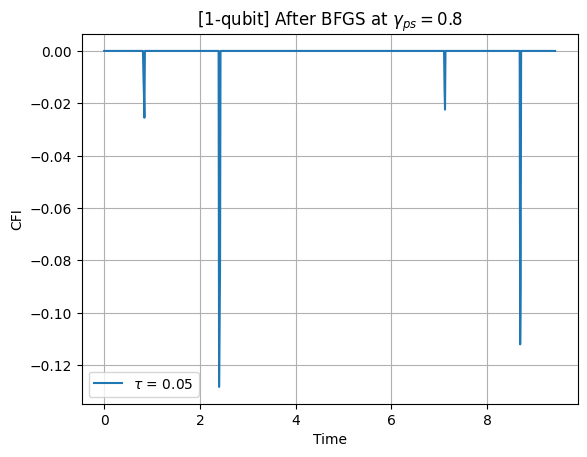

In [8]:
tau_plot = 5e-2,

Sweep_data = np_.array([0, np.pi*3,  1e-2])  #1e-2 ~ (4pi + 1e-2)
Sweep_data_arange = np_.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for idx,tau_current in enumerate(tau_plot):
    Tau_global = tau_current
    
    Paras_init = np.zeros(2)
    Paras_init[:2] = (1.1*np.pi)/2    # 1.1pi/2
    # Paras_init = np.array([np.pi/2, 2.67])

    Gamma_ps_preset = 8e-1
    Set_Iterations = 1

    Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)
    
    Para_store[idx][:, 0] = Optimized_Result[Set_Iterations][:,DataIndex.THETA_X.value]
    Para_store[idx][:, 1] = Optimized_Result[Set_Iterations][:,DataIndex.PHI_Z.value]
    
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, DataIndex.CFI.value], label = f'$\\tau$ = {tau_current}')
    
plt.title(f'[1-qubit] After BFGS at $\gamma_{{ps}} = {Gamma_ps_preset}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

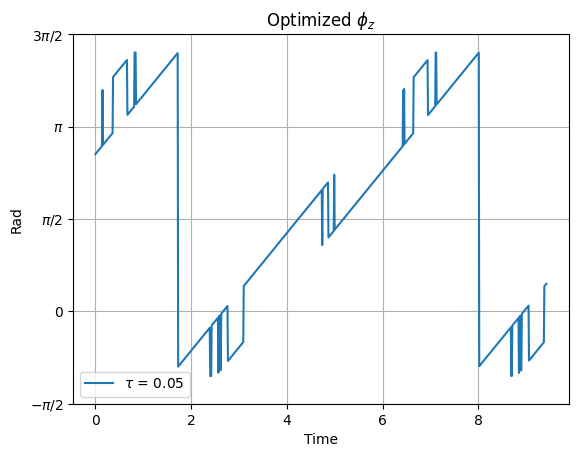

In [9]:
for idx, tau in enumerate(tau_plot):
    # if idx, tau != 4:
        plt.plot(Sweep_data_arange, Para_store[idx][:, 1], label = f'$\\tau$ = {tau}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 4*np.pi/2, 5*np.pi/2], ['$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$', '$5\pi/2$'])
plt.ylim(-np.pi/2, 3*np.pi/2)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [10]:
# indices = np_.where(Para_store[1][:, 1] <= 2e-1)
indices = np_.where((1.3*np.pi <= Para_store[0][:, 1]) & (Para_store[0][:, 1] <= 1.5*np.pi))

indices

(array([ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  82,  83,  84, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687,
        688, 689, 690, 691, 692, 693, 694, 711, 712, 770, 771, 772, 773,
        774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786,
        787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799,
        800, 801]),)

In [11]:
# Para_store[0][173+314, 1]
Para_store[0][158+316, 1]

# 4.24006637 / np.pi

tensor(1.12688106, requires_grad=True)

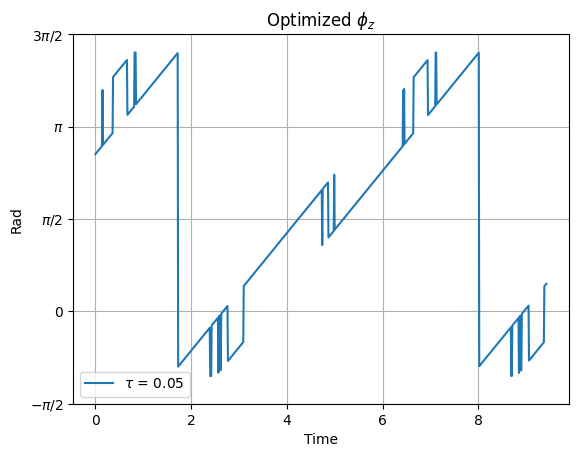

In [12]:
slice = int(len(Sweep_data_arange) / 1)

tau_order = 0,

for idx, tau in enumerate(tau_order):
    plt.plot(Sweep_data_arange[:slice], Para_store[tau][:slice, 1], label = f'$\\tau$ = {tau_plot[tau]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-1*np.pi/2, 3*np.pi/2)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [13]:
Para_store[0][0, 1]

tensor(2.67006637, requires_grad=True)

In [14]:
# indices = np_.where(Para_store[1][:, 1] <= 2e-1)
indices = np_.where(Para_store[0][:, 1] > 2*np.pi)

indices

(array([], dtype=int64),)

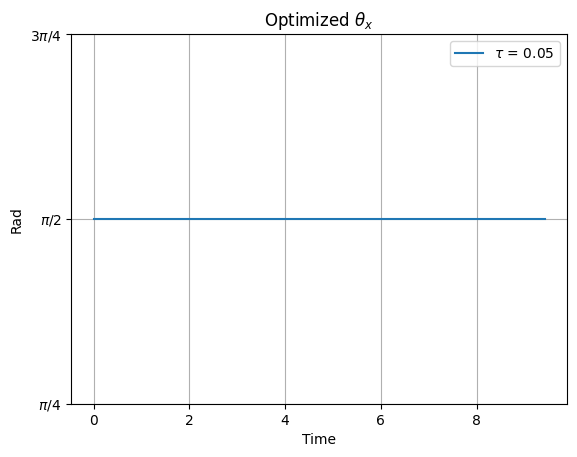

In [15]:
for idx, tau in enumerate(tau_plot):
    plt.plot(Sweep_data_arange, Para_store[idx][:, 0], label = f'$\\tau$ = {tau}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()